In [1]:
import tensorflow as tf
from research.object_detection.utils import dataset_util
from research.object_detection.utils import visualization_utils as viz_utils
from research.object_detection.utils import label_map_util
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import numpy as np 
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
#matplotlib.use('TkAgg')
#import tkinter 
#import ast

In [2]:
record_train = "data/muscima/training.record"
record_validation = "data/muscima/validation.record"
record_test = "data/muscima/test.record"

class_map = "mapping_all_classes.txt"

###Utility Functions

In [3]:
def generate_omr_dataset_from_tfrecord(filename: str):
    dataset = tf.data.TFRecordDataset(filename)

    dataset = dataset.map(
        parse_omr_element
        )

    return dataset

    
def parse_omr_element(element):

    data = {
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/filename': tf.io.FixedLenFeature([], tf.string),
    'image/source_id': tf.io.FixedLenFeature([], tf.string),
    #'image/key/sha256':tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    #'image/encoded': tf.io.decode_png([], channels=0),
    'image/format': tf.io.FixedLenFeature([], tf.string),
    
    'image/object/bbox/xmin': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
    #'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
    'image/object/bbox/ymin': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
    'image/object/bbox/ymax': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
    #'image/object/class/text': tf.io.FixedLenSequenceFeature([], tf.string, allow_missing=True),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    'image/object/class/label': tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
    }


    example = tf.io.parse_single_example(element, data)

    example['image/decoded'] = tf.io.decode_image(example.get('image/encoded'))

    example_np_xmin = example['image/object/bbox/xmin']
    example_np_xmax = example['image/object/bbox/xmax']
    example_np_ymin = example['image/object/bbox/ymin']
    example_np_ymax = example['image/object/bbox/ymax']
    
    example_np_bbox = tf.stack((example_np_ymin, example_np_xmin, example_np_ymax, example_np_xmax))

    example['image/bbox'] = tf.transpose(example_np_bbox)

    # get rid of irrelevant objects
    example.pop('image/encoded')
    example.pop('image/format')
    example.pop('image/object/bbox/xmin')
    example.pop('image/object/bbox/ymin')
    example.pop('image/object/bbox/xmax')
    example.pop('image/object/bbox/ymax')

    return example


def plot_detections(image_np,
                    boxes,
                    classes, 
                    scores, 
                    category_index, 
                    figsize=(12,16),
                    image_name=None):
    image_np_with_annotations = image_np.copy()
    image_np_with_annotations = np.repeat(image_np_with_annotations, 3, 2)
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8,
        max_boxes_to_draw=scores.shape[0]
    )
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)
        plt.show()

In [4]:
training_dataset = generate_omr_dataset_from_tfrecord(record_train)
validation_dataset = generate_omr_dataset_from_tfrecord(record_validation)
test_dataset = generate_omr_dataset_from_tfrecord(record_test)


In [5]:
# convert the label map to a suitable format

label_map_dict_raw = label_map_util.get_label_map_dict(class_map)

label_map_dict = {}

for key in label_map_dict_raw.keys():
    value = {
        'id': label_map_dict_raw.get(key),
        'name': key
    }
    label_map_dict[label_map_dict_raw.get(key)] = value

In [6]:
def plot_detections_from_dataset_element(element):
  dummy_scores = np.repeat(np.array([1.0], dtype=np.float32), element['image/object/class/label'].shape[0])
  image_np = element['image/decoded'].numpy().copy()
  image_np = np.repeat(image_np, 3, 2)
  boxes_np = element['image/bbox'].numpy()
  classes_np = element['image/object/class/label'].numpy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np,
                boxes=boxes_np,
                classes=classes_np,
                scores=dummy_scores,
                category_index=label_map_dict,
                use_normalized_coordinates=True,
                min_score_thresh = 0.8,
                max_boxes_to_draw=500
  )
  plt.figure(figsize=(30,15))
  plt.imshow(image_np)
  plt.show()


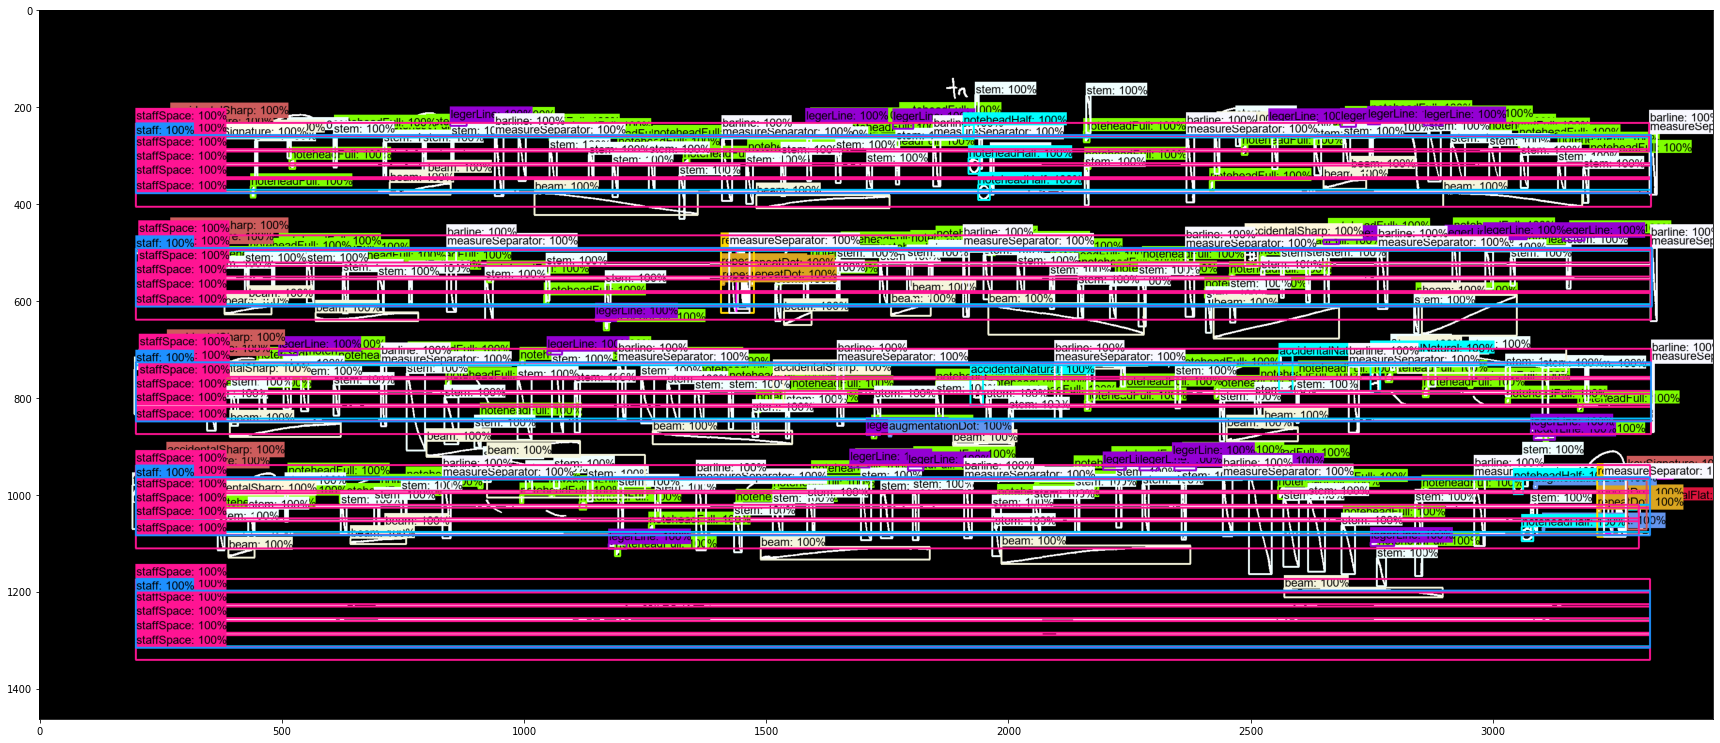

In [7]:
#Visualize an element from the training dataset

sample = training_dataset.take(1)
td_element = sample.get_single_element()

plot_detections_from_dataset_element(td_element)

Inference:

In [8]:
import time

In [12]:
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load('export/saved_model/')
#detect_fn = tf.saved_model.load('export/tflite/saved_model/')
# doesn't even work, wow
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 25.533000946044922s


In [14]:
detect_fn

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x24f4fc43310>

In [13]:
detect_fn2 = tf.saved_model.load('export/saved_model/')

In [15]:
detect_fn2

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x24fba2bfa00>

In [17]:
sample = training_dataset.take(1)
td_element = sample.get_single_element()
image_np = np.expand_dims(np.repeat(td_element['image/decoded'].numpy(), 3, 2), 0)

image_np.shape

detections = detect_fn(image_np)


In [ ]:
image_np_with_detections = image_np[0].copy()
boxes = detections['detection_boxes'][0].numpy()
classes = detections['detection_classes'][0].numpy().astype(np.int32)
scores = detections['detection_scores'][0].numpy()

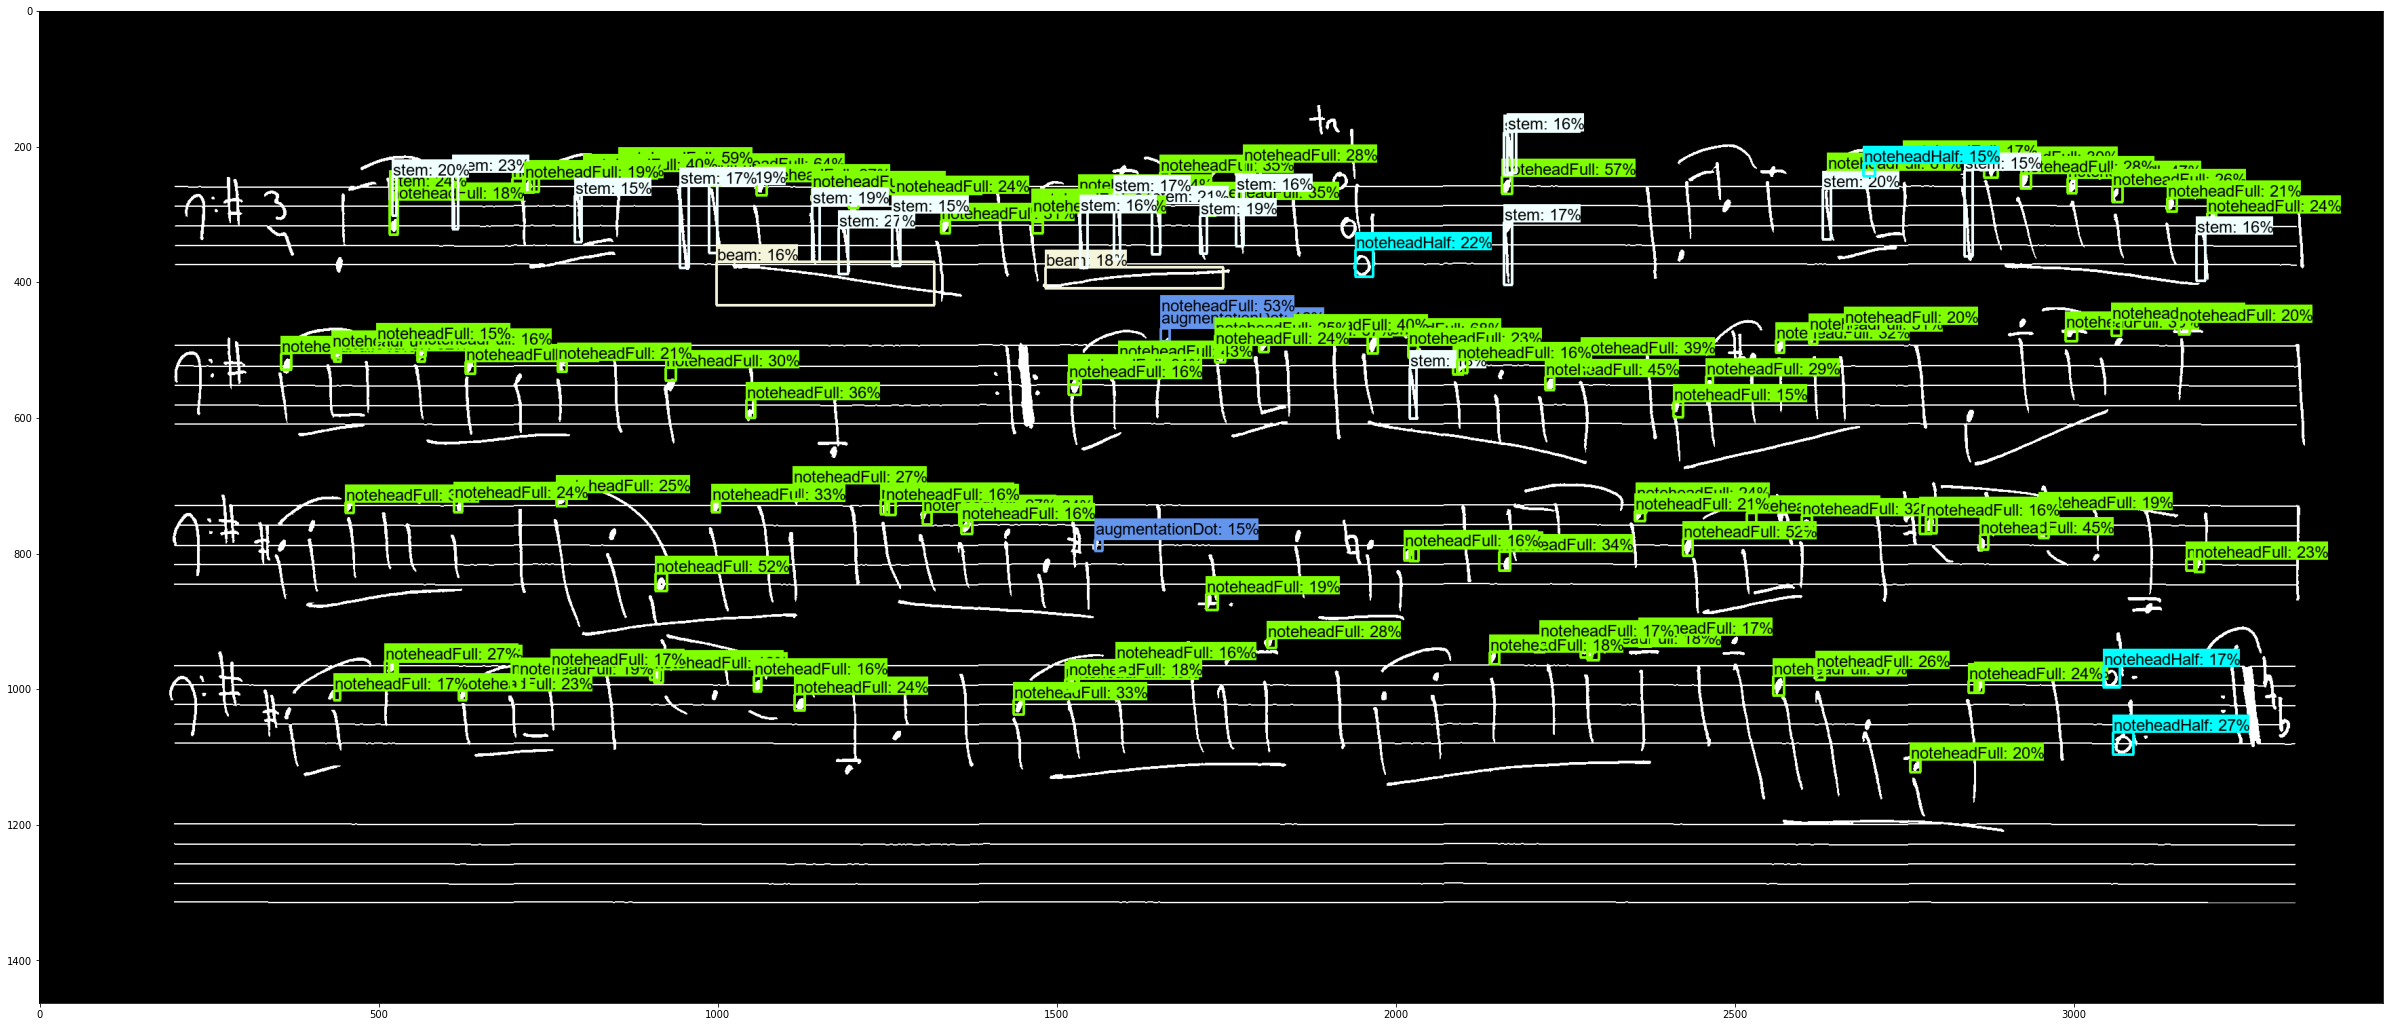

In [ ]:

plt.rcParams['figure.figsize'] = [42, 21]
viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        boxes=boxes,
        classes=classes,
        scores=scores,
        category_index=label_map_dict,
        use_normalized_coordinates=True,
        max_boxes_to_draw=1200,
        min_score_thresh=0.15,
        agnostic_mode=False)
plt.imshow(image_np_with_detections)